# Setup

In [ ]:
#install.packages("eeptools") # to calculate ages
#install.packages("apaTables")
#install.packages("tableone")


In [38]:
system("sudo su -c 'curl https://packages.microsoft.com/config/rhel/7/prod.repo > /etc/yum.repos.d/mssql-release.repo && exit'")
system("sudo yum remove unixODBC-utf16 unixODBC-utf16-devel")
system("sudo ACCEPT_EULA=Y yum install -y msodbcsql17")
system("sudo ACCEPT_EULA=Y yum install -y mssql-tools")
system("echo 'export PATH='$PATH:/opt/mssql-tools/bin'' >> ~/.bashrc")
system("source ~/.bashrc")
system("sudo yum install -y unixODBC-devel")

In [2]:
#install.packages("odbc")
#install.packages("DBI")
#install.packages("rstudioapi")

library(odbc)
library(dplyr)
library(stringr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [39]:
file_path <- '/home/ec2-user/SageMaker/db-credentials.txt'
db_creds_df <- read.table(file_path)
db_creds <- db_creds_df$V3
names(db_creds) <- db_creds_df$V1
db_creds <- trimws(db_creds)
#db_creds

In [40]:
# load database
db <- 'S35'

In [41]:
connection_string = paste0("DRIVER={ODBC Driver 17 for SQL Server};",
                          "SERVER=", db_creds['host'], ',', db_creds['port'], ';',
                          "DATABASE=", db, ';',
                          "UID=", db_creds['username'], ';',
                          "PWD={", db_creds['password'], "};")

#connection_string

In [42]:
db_conn <- DBI::dbConnect(odbc::odbc(), .connection_string = connection_string)

# ICD names

Loading ICD names to join to datasets and filter using keywords

In [ ]:
icdnames<-dbGetQuery(db_conn, "select * from S35.dbo.ICDnames;")
icdnames<-icdnames %>% select(-CONCEPT_PATH)

# DEMOGRAPHICS

In [43]:
#select patient demographics (subsample of 100 pts)
demo<-dbGetQuery(db_conn,"select * from S35.dbo.phqdemographics;")


Selecting only on the Phq-9 which is PRO:ADV0014. PRO:ADV0045 is the PHQ-2. Specificty isn't quite as high as the PHQ9 but there are far more administered.

# Coding the factor levels for Demographic Variables

In [ ]:
demo %>% head()

In [ ]:
library(haven)
library(purrr)
library(apaTables)

In [44]:
complete.demo<-complete.df %>% as.matrix() %>% as.data.frame() %>% mutate(
    BIRTH_DATE=as_date(BIRTH_DATE),
    AdminDate=as_date(AdminDate),
Age=age_calc(dob = BIRTH_DATE, enddate = AdminDate, units = "years"))  %>% 
mutate(FPL=case_match(CURRENT_FPL_CD,"DEM|FPL:<=100"~"FPL Below 100","DEM|FPL:151-200"~"FPL 151-200","DEM|FPL:UN"~"FPL Unknown","DEM|FPL:>200
"~"FPL Over 200", "DEM|FPL:101-150"~"FPL 101-150"),
 Marital=case_match(MARITAL_STATUS_CD,"DEM|MARITAL:Other"~"Other",
"DEM|MARITAL:Widowed"~"Widowed",
"DEM|MARITAL:Divorced"~"Divorced",
"DEM|MARITAL:Separated"~"Separated",
"DEM|MARITAL:Domestic Partner"~"Domestic Partner",
"DEM|MARITAL:Significant Other"~"Significant Other",
"DEM|MARITAL:Married"~"Married",
"DEM|MARITAL:Single"~"Single",
"DEM|MARITAL:NI"~"Marital NI"),
Gender=case_match(GENDER_CD,"DEM|GENDER:TG"~"Transgender",
"DEM|GENDER:GQ"~"Genderqueer",
"DEM|GENDER:UN"~"Unknown / Missing",
"DEM|GENDER:OT"~"Other",
"DEM|GENDER:M"~"Man",
"DEM|GENDER:W"~"Woman"),
Race=case_match(RACE_CD,"DEM|RACE:02"~"Asian",
"DEM|RACE:06"~"Multiple race",
"DEM|RACE:01"~"American Indian or Alaskan Native",
"DEM|RACE:05"~"White",
"DEM|RACE:03"~"Black or African American",
"DEM|RACE:07"~"Refuse to answer",
"DEM|RACE:04"~"Native Hawaiian or Other Pacific Islander",
"DEM|RACE:OT"~"Other"),
Rural=case_match(RURAL_CD,"DEM|RURAL:Y"~"Yes",
"DEM|RURAL:N"~"No"),
Sex=case_match(SEX_CD,"DEM|SEX:NI"~"Sex No Information",
"DEM|SEX:F"~"Female",
"DEM|SEX:M"~"Male",
"DEM|SEX:UN"~"Sex Unknown"),
Sexor=case_match(SEXORIENTATION_CD,"DEM|SEXORIENTATION:GA"~"Gay",
"DEM|SEXORIENTATION:SE"~"Something else",
"DEM|SEXORIENTATION:LE"~"Lesbain",
"DEM|SEXORIENTATION:ST"~"Straight",
"DEM|SEXORIENTATION:MU"~"Multiple sexual orientations",
"DEM|SEXORIENTATION:UN"~"Unknown/ Missing",
"DEM|SEXORIENTATION:BI"~"Bisexual",
"DEM|SEXORIENTATION:QU"~"Queer"))%>% 
mutate(across(c(HEALTH_SYSTEM_ID,CURRENT_FPL_CD:SEXORIENTATION_CD,FPL:Sexor),~factor(.)))


ERROR: Error in eval(expr, envir, enclos): object 'complete.df' not found


# PHQ

# CURRENT WORKING BAND

In [ ]:
phqcomplete<-dbGetQuery(db_conn,"select * from S35.dbo.phqcomplete;")

In [ ]:
## phqcomplete with depression or hyp filter
phqcomplete<-phqcomplete %>% left_join(icdnames)


In [ ]:
#playing with doing vitals in the dataset in one go to avoid merge problems
phqnewcols<-phqcomplete %>%  mutate(NAME_CHAR=
       case_when(
       str_detect(NAME_CHAR,"Depress")~"Depressed",
       str_detect(NAME_CHAR,"Type II|Type 2|Diabetes")~"Diabetes",
       str_detect(NAME_CHAR,"Hyperlipidemia")~"Hyperlipidemia",
       str_detect(NAME_CHAR,"Hypertens")~"Hypertension",
       str_detect(NAME_CHAR,"Obesity")~"Obesity"
       #.default=NAME_CHAR
       ))%>% mutate(Vitals=
      case_when(
       str_detect(CONCEPT_CD,"BMI")~"BMI", 
       str_detect(CONCEPT_CD,"SYS")~"SystolicBP", 
       str_detect(CONCEPT_CD,"DIAS")~"DiastolicBP",
       str_detect(CONCEPT_CD,"PRO:ADV0039")~"Audit",
       str_detect(CONCEPT_CD,"PRO:ADV0045")~"Phq2",
      )) 

In [ ]:
phqcomplete %>% group_by(NAME_CHAR) %>% tally() %>% arrange(desc(n)) %>% write.csv("ConditionTally.csv")

In [ ]:
# ALTERNATIVE VERSION THAT INCLUDES OTHER DIAGNOSES IN THE SAMPLE
phqalldx<-phqcomplete %>%  mutate(NAME_CHAR=
       case_when(
       str_detect(NAME_CHAR,"Depress|Dysthymic")~"Depressed",
       str_detect(NAME_CHAR,"Type II|Type 2|Diabetes")~"Diabetes",
       str_detect(NAME_CHAR,"Hyperlipidemia")~"Hyperlipidemia",
       str_detect(NAME_CHAR,"Hypertens")~"Hypertension",
       str_detect(NAME_CHAR,"Obesity")~"Obesity",
       str_detect(NAME_CHAR,"Adjustment")~"Adjustment",      
       str_detect(NAME_CHAR,"Anxiety|Panic|Agoraphobia")~"Anxiety",
       str_detect(NAME_CHAR,"Posttraumatic|Post-traumatic")~"PTSD",
       str_detect(NAME_CHAR,"Sleep|Insomnia|F51")~"Sleep",
       str_detect(NAME_CHAR,"Bipolar|Manic")~"Bipolar",
       str_detect(NAME_CHAR,"Nicotine|Tobacco")~"Tobacco",
       str_detect(NAME_CHAR,"Opioid|F11|F12|F13|F14|F15|F16|F18|F19")~"SUD",
       str_detect(NAME_CHAR,"Alcohol|F10")~"Alcohol",
       str_detect(NAME_CHAR,"Schiz|Delusional|F23|F24|F28|F29")~"SchizophreniaSpectrum",     
       str_detect(NAME_CHAR,"Eating|F50")~"EatingDisorders"    
       #.default=NAME_CHAR
       ))%>% mutate(Vitals=
      case_when(
       str_detect(CONCEPT_CD,"BMI")~"BMI", 
       str_detect(CONCEPT_CD,"SYS")~"SystolicBP", 
       str_detect(CONCEPT_CD,"DIAS")~"DiastolicBP",
       str_detect(CONCEPT_CD,"PRO:ADV0039")~"Audit",
       str_detect(CONCEPT_CD,"PRO:ADV0045")~"Phq2",
      )) 

In [ ]:
#Save file from above in case the kernal crashes
save(phqalldx,file="phqalldx.RData")

In [4]:
load('/home/ec2-user/SageMaker/phqalldx.RData')

In [5]:
# Reducing the size of the dataset for pivoting
phqfewercols<-phqalldx  %>%  filter(str_detect(CONCEPT_CD,"ICD|ADV0014|ADV0045|ADV0039|BMI|SYS|DIAS"))

In [ ]:
phqfewercols %>% nrow() #14921844

In [ ]:
evenphqfewer<-phqfewercols %>% filter(PhqScore>=10|PhqScore<=4) #limiting to phq extremes to run

In [ ]:
evenphqfewer %>% nrow()

In [6]:
# rearranging data into wide format: the vitals. formerly phqfewer here
phqwide<-phqfewercols %>% unique() %>% mutate(n=1) %>% 
select(n,phqPT,PhqScore,phqEnc,AdminDate,TVAL_CHAR,NAME_CHAR,INSTANCE_NUM,CONCEPT_CD,NVAL_NUM,HEALTH_SYSTEM_ID,PROVIDER_ID,Vitals)%>% pivot_wider(names_from=Vitals,values_from=NVAL_NUM) 

In [7]:
save(phqwide,file="wide_vitals.RData")

In [3]:
load('/home/ec2-user/SageMaker/wide_vitals.RData')

In [8]:
#checking data integrity
phqwide %>% filter(Audit>1)

n,phqPT,PhqScore,phqEnc,AdminDate,TVAL_CHAR,NAME_CHAR,INSTANCE_NUM,CONCEPT_CD,HEALTH_SYSTEM_ID,PROVIDER_ID,NA,Audit,Phq2,BMI,DiastolicBP,SystolicBP
<dbl>,<int>,<dbl>,<int>,<dttm>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8109461,6,129466629,2019-06-21,E,NA,2,PRO:ADV0039,739,859CCCCE-6917-41FD-98FC-0A22A10EE052,NA,2,NA,NA,NA,NA
1,8103638,17,129467885,2019-04-18,E,NA,1,PRO:ADV0039,739,46F49C56-0337-4656-A563-8FFF82070C97,NA,2,NA,NA,NA,NA
1,8109280,2,129467891,2019-03-25,E,NA,1,PRO:ADV0039,739,1F8BD698-1432-4786-91B5-9105FAD6390C,NA,4,NA,NA,NA,NA
1,9595480,10,129468656,2018-10-04,E,NA,3,PRO:ADV0039,739,7EABBDF5-D036-499A-A5CD-067978F21050,NA,13,NA,NA,NA,NA
1,9595784,0,129470583,2019-09-19,E,NA,1,PRO:ADV0039,739,64B40124-B255-4355-B639-933DBF01543E,NA,16,NA,NA,NA,NA
1,9592157,3,129470856,2018-11-27,E,NA,2,PRO:ADV0039,739,D34DCC8A-61BF-4ED6-A8D6-D7E0F31C914F,NA,4,NA,NA,NA,NA
1,9588105,3,129470910,2018-11-09,E,NA,2,PRO:ADV0039,739,5F22C01B-0393-4904-84E1-A3145004AE0A,NA,6,NA,NA,NA,NA
1,9592492,7,129488342,2018-07-25,E,NA,3,PRO:ADV0039,739,938EF875-FB3A-4A27-B121-6092DC030A04,NA,9,NA,NA,NA,NA
1,9595799,15,129502084,2018-11-14,E,NA,3,PRO:ADV0039,739,EADBD4E6-38EF-4059-83B9-2173D18557A6,NA,7,NA,NA,NA,NA


In [4]:
# rearranging wide icd codes
phqwide<-phqwide%>% 
select(n,phqPT,PhqScore,phqEnc,AdminDate,NAME_CHAR,INSTANCE_NUM,CONCEPT_CD,HEALTH_SYSTEM_ID,PROVIDER_ID,BMI,SystolicBP,DiastolicBP,Audit,Phq2) %>% pivot_wider(names_from=NAME_CHAR,values_from=n,values_fill=0)

In [5]:
save(phqwide,file="phqwide_icd.RData")

In [ ]:
# integrity check again
phqwide %>% filter(Depressed==1)

In [ ]:
phqwide %>% colnames()

In [6]:
load('/home/ec2-user/SageMaker/phqwide_icd.RData')

In [7]:
# eliminating unlikely entries
phqwide<-phqwide%>% 
mutate(BMI=case_when(BMI>200|BMI<7~NA_real_,.default=BMI)) %>% 
mutate(SystolicBP=case_when(SystolicBP>300|SystolicBP<50~NA_real_,.default=SystolicBP)) %>% 
mutate(DiastolicBP=case_when(DiastolicBP>300|DiastolicBP<40~NA_real_,.default=DiastolicBP))%>%
mutate(Audit=case_when(Audit>40|Audit<0~NA_real_,.default=Audit))

In [13]:
phqcollapse<-phqwide %>% group_by(phqPT,phqEnc) %>%  fill(everything(), .direction = "up")  %>% 
fill(everything(), .direction = "down") %>% slice(1)

In [15]:
save(phqcollapse,file="notindivid.RData")

In [ ]:
# checking for duplicates and its all good

#phqcollapse %>% unique() %>%  ungroup() %>% dplyr::summarise(n = dplyr::n(), .by = c(phqPT, PhqScore, phqEnc,INSTANCE_NUM,CONCEPT_CD,AdminDate)) %>% 
#dplyr::filter(n > 1L)

In [16]:
phqcollapse %>% nrow() #2843429

[1] 2843429

In [17]:
# now I also need to to grab the first instance of an encounter/admindate
phqfirst<-phqcollapse %>% group_by(phqPT) %>% slice_min(AdminDate)

Exclude if no bmi available

In [26]:
phqfirst1<-phqfirst %>% filter(!is.na(BMI))

In [31]:
phqfirst1 %>% filter(phqPT==45612) %>% select(Obesity:PTSD)

Adding missing grouping variables: `phqPT`


phqPT,Obesity,Hyperlipidemia,Depressed,Bipolar,Anxiety,Alcohol,Sleep,SUD,Tobacco,SchizophreniaSpectrum,Adjustment,EatingDisorders,Hypertension,PTSD
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
45612,0,0,0,0,0,0,0,0,0,0,0,0,0,0
45612,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
#for the 303 remaining with duplicate records on the same day, took random selection
phqfirst2<-phqfirst1 %>% group_by(phqPT) %>% slice_sample(n=1)

In [34]:
phqfirst2 %>% unique() %>%  ungroup() %>% dplyr::summarise(n = dplyr::n(), .by = c(phqPT)) %>% 
dplyr::filter(n > 1L) #no double records remain

phqPT,n
<int>,<int>


In [86]:
phqcollapse %>% head()

phqPT,PhqScore,phqEnc,AdminDate,INSTANCE_NUM,CONCEPT_CD,HEALTH_SYSTEM_ID,PROVIDER_ID,BMI,SystolicBP,⋯,Anxiety,Alcohol,Sleep,SUD,Tobacco,SchizophreniaSpectrum,Adjustment,EatingDisorders,Hypertension,PTSD
<int>,<dbl>,<int>,<dttm>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
555,21,35344548,2014-08-08,1,ICD9CM:300.00,692,2949F791-E57E-494D-9A3C-2F742E5044BF,28.48,118,⋯,1,0,0,0,0,0,0,0,0,0
560,16,31580615,2013-08-12,1,ICD9CM:311,564,AE5F21AE-72A1-4004-9F4C-3B29714EE261,38.29,120,⋯,0,0,0,0,0,0,0,0,0,0
560,9,31911390,2013-11-20,1,ICD9CM:311,564,AE5F21AE-72A1-4004-9F4C-3B29714EE261,39.90,106,⋯,0,0,0,0,0,0,0,0,0,0
560,5,31973297,2016-05-26,1,ICD10CM:E78.2,564,AE5F21AE-72A1-4004-9F4C-3B29714EE261,40.19,130,⋯,0,0,0,0,0,0,0,0,0,0
560,19,32305700,2013-08-05,1,ICD9CM:311,564,AE5F21AE-72A1-4004-9F4C-3B29714EE261,38.22,140,⋯,0,0,0,0,0,0,0,0,0,0
573,0,82437185,2018-08-15,1,ICD10CM:E78.2,641,4C81DF3C-077B-4749-9EB0-4A6C6D126BCF,34.60,136,⋯,0,0,0,0,0,0,0,0,0,0


In [35]:
save(phqfirst2,file="phqfirst.RDS")

In [89]:
load(file="/home/ec2-user/SageMaker/phqfirst.RDS")

In [49]:
load(file="/home/ec2-user/SageMaker/complete.RData")

In [90]:
phqfirst2 %>% filter(Depressed==1)

phqPT,PhqScore,phqEnc,AdminDate,INSTANCE_NUM,CONCEPT_CD,HEALTH_SYSTEM_ID,PROVIDER_ID,BMI,SystolicBP,⋯,Anxiety,Alcohol,Sleep,SUD,Tobacco,SchizophreniaSpectrum,Adjustment,EatingDisorders,Hypertension,PTSD
<int>,<dbl>,<int>,<dttm>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
560,19,32305700,2013-08-05,1,ICD9CM:311,564,AE5F21AE-72A1-4004-9F4C-3B29714EE261,38.22,140,⋯,0,0,0,0,0,0,0,0,0,0
647,14,18173681,2017-10-02,1,ICD10CM:F33.1,667,D214E73D-D93B-4151-9166-019096D31829,20.18,112,⋯,0,0,0,0,0,0,0,0,0,0
817,21,14906683,2017-09-06,1,ICD10CM:F32.89,648,5207C678-C587-462D-B25D-DF2C2ED9E14F,24.33,103,⋯,0,0,0,0,0,0,0,0,0,0
867,4,20652705,2016-11-09,1,ICD10CM:F32.5,605,0C8B1024-34BE-4A5D-8363-ECCB8F8903F7,22.13,146,⋯,0,0,0,0,0,0,0,0,0,0
921,11,60038328,2012-12-19,1,ICD9CM:311,558,55612BAD-6F99-4520-A887-686786E34CE6,25.31,126,⋯,0,0,0,0,0,0,0,0,0,0
1248,11,71981807,2017-12-12,1,ICD10CM:F32.9,594,D67BA8E5-BF1F-47D8-94D9-16ADADD575D9,23.00,108,⋯,0,0,0,0,0,0,0,0,0,0
1278,17,75148316,2017-09-21,1,ICD10CM:F33.2,606,C7B48665-59E2-4E91-B19E-73192D727C8E,37.40,157,⋯,0,0,0,0,0,0,0,0,0,0
1491,11,40227280,2017-01-25,1,ICD10CM:F33.1,678,0838A91C-423E-4844-B541-19BD973D7066,36.91,98,⋯,0,0,0,0,0,0,0,0,0,0
1529,14,28185859,2018-02-12,1,ICD10CM:F33.1,679,691A946E-1C87-4902-B384-F690CC65C3E8,32.35,116,⋯,0,0,0,0,0,0,0,0,0,0


In [56]:
complete.demo %>% colnames()

[1] "phqPT"              "PhqScore"           "phqEnc"            
 [4] "AdminDate"          "INSTANCE_NUM"       "CONCEPT_CD"        
 [7] "HEALTH_SYSTEM_ID"   "PROVIDER_ID"        "BMI"               
[10] "SystolicBP"         "DiastolicBP"        "Diabetes"          
[13] "NA"                 "Obesity"            "Hyperlipidemia"    
[16] "Depressed"          "Hypertension"       "BIRTH_DATE"        
[19] "CURRENT_FPL_CD"     "HISPANIC_CD"        "GENDER_CD"         
[22] "HOMELESS_CD"        "LANGUAGE_CD"        "MARITAL_STATUS_CD" 
[25] "RACE_CD"            "RURAL_CD"           "SEX_CD"            
[28] "SEXORIENTATION_CD"  "VITAL_STATUS_CD"    "phqDepressed"      
[31] "phqSevereDepressed" "DepAny"             "Age"               
[34] "FPL"                "Marital"            "Gender"            
[37] "Race"               "Rural"              "Sex"               
[40] "Sexor"

In [57]:
demomerge<-complete.demo %>% select(phqPT,phqEnc,AdminDate,phqDepressed:Sexor)

THis is real slipshod but I when I loaded the coded demographic data, some of the fields no longer matched the main phq file

In [98]:
demomerge %>% head()
demomergenum<-demomerge
demomergenum$phqPT<-as.numeric(as.character(demomerge$phqPT))
demomergenum$phqEnc<-as.numeric(as.character(demomerge$phqEnc))
demomergenum$phqDepressed<-as.numeric(as.character(demomerge$phqDepressed))
demomergenum$phqSevereDepressed<-as.numeric(as.character(demomerge$phqSevereDepressed))
demomergenum$DepAny<-as.numeric(as.character(demomerge$DepAny))

,phqPT,phqEnc,AdminDate,phqDepressed,phqSevereDepressed,DepAny,Age,FPL,Marital,Gender,Race,Rural,Sex,Sexor
,<chr>,<chr>,<date>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,555,35344548,2014-08-08,1,1,1,55.18904,FPL Below 100,Marital NI,Unknown / Missing,White,Yes,Male,Unknown/ Missing
2,560,31580615,2013-08-12,1,0,1,62.58356,FPL Unknown,Marital NI,Unknown / Missing,White,No,Female,Unknown/ Missing
3,560,32305700,2013-08-05,1,0,1,62.56438,FPL Unknown,Marital NI,Unknown / Missing,White,No,Female,Unknown/ Missing
4,573,82437185,2018-08-15,0,0,0,50.44932,FPL Below 100,Married,Unknown / Missing,White,No,Male,Unknown/ Missing
5,573,82985825,2018-05-22,0,0,0,50.21644,FPL Below 100,Married,Unknown / Missing,White,No,Male,Unknown/ Missing
6,573,84586881,2018-04-20,0,0,0,50.12877,FPL Below 100,Married,Unknown / Missing,White,No,Male,Unknown/ Missing


In [59]:
phqfirst2<-phqfirst2 %>% as.matrix() %>% as.data.frame()

In [99]:
phq.df<-left_join(phqfirst2,demomergenum,by=join_by(phqPT,phqEnc))

In [100]:
phqfirst2 %>% nrow() #985645
phq.df %>% nrow() #985645

[1] 985645

[1] 985645

In [102]:
save(phq.df,file="phqall_demo.RData")

In [75]:
# temp to get code to run uses complete cases. It's like a 40% reduction in sample :( and it would be better to impute)
completecases.df<-phq.df %>% ungroup() %>% rowwise() %>%  drop_na(HEALTH_SYSTEM_ID:Sexor)
completecases.df %>% nrow()

[1] 43342

In [103]:
phq.df %>% filter(Depressed==1)

phqPT,PhqScore,phqEnc,AdminDate.x,INSTANCE_NUM,CONCEPT_CD,HEALTH_SYSTEM_ID,PROVIDER_ID,BMI,SystolicBP,⋯,phqSevereDepressed,DepAny,Age,FPL,Marital,Gender,Race,Rural,Sex,Sexor
<dbl>,<dbl>,<dbl>,<dttm>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
560,19,32305700,2013-08-05,1,ICD9CM:311,564,AE5F21AE-72A1-4004-9F4C-3B29714EE261,38.22,140,⋯,0,1,62.56438,FPL Unknown,Marital NI,Unknown / Missing,White,No,Female,Unknown/ Missing
647,14,18173681,2017-10-02,1,ICD10CM:F33.1,667,D214E73D-D93B-4151-9166-019096D31829,20.18,112,⋯,0,1,27.17808,FPL Unknown,Single,Woman,White,No,Female,Straight
817,21,14906683,2017-09-06,1,ICD10CM:F32.89,648,5207C678-C587-462D-B25D-DF2C2ED9E14F,24.33,103,⋯,1,1,36.45753,FPL Below 100,Marital NI,Man,White,No,Male,Unknown/ Missing
867,4,20652705,2016-11-09,1,ICD10CM:F32.5,605,0C8B1024-34BE-4A5D-8363-ECCB8F8903F7,22.13,146,⋯,0,1,43.27869,FPL Below 100,Single,Woman,NA,No,Female,Straight
921,11,60038328,2012-12-19,1,ICD9CM:311,558,55612BAD-6F99-4520-A887-686786E34CE6,25.31,126,⋯,0,1,58.33333,FPL 101-150,Widowed,Woman,White,Yes,Female,Unknown/ Missing
1248,11,71981807,2017-12-12,1,ICD10CM:F32.9,594,D67BA8E5-BF1F-47D8-94D9-16ADADD575D9,23.00,108,⋯,0,1,19.68219,FPL Below 100,Single,Unknown / Missing,White,No,Male,Unknown/ Missing
1278,17,75148316,2017-09-21,1,ICD10CM:F33.2,606,C7B48665-59E2-4E91-B19E-73192D727C8E,37.40,157,⋯,0,1,62.33425,NA,Divorced,Unknown / Missing,White,No,Female,Unknown/ Missing
1491,11,40227280,2017-01-25,1,ICD10CM:F33.1,678,0838A91C-423E-4844-B541-19BD973D7066,36.91,98,⋯,0,1,36.55209,FPL Unknown,Divorced,Woman,White,No,Female,Unknown/ Missing
1529,14,28185859,2018-02-12,1,ICD10CM:F33.1,679,691A946E-1C87-4902-B384-F690CC65C3E8,32.35,116,⋯,0,1,24.60000,FPL Below 100,Marital NI,Man,White,No,Male,Straight


In [108]:
# then get rid of bad values in phq, round some of the weird values and summarise to check
cleanphq.df<-phq.df %>% filter(PhqScore>0 & PhqScore<28)  %>% mutate(PhqScore=round(PhqScore))
cleanphq.df%>% group_by(Depressed) %>% summarise(mean=mean(PhqScore),sd=sd(PhqScore),min=min(PhqScore),max=max(PhqScore))

Depressed,mean,sd,min,max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,9.051658,6.505694,0,27
1,14.107443,6.460548,0,27


In [110]:
providers<-read.csv('/home/ec2-user/SageMaker/providersepped.csv')


In [ ]:
nrow(providers)

In [115]:
providers %>% group_by(L1) %>% tally() %>% arrange(desc(n))

L1,n
<chr>,<int>
Allopathic & Osteopathic Physicians,6706
Physician Assistants & Advanced Practice Nursing Providers,4227
Behavioral Health & Social Service Providers,2747
Other Service Providers,909
Dental Providers,795
Nursing Service Providers,780
"Student, Health Care",495
Eye and Vision Services Providers,210
Pharmacy Service Providers,186


In [111]:
phqdfproviders<-cleanphq.df %>% left_join(providers)

Joining with `by = join_by(PROVIDER_ID)`


In [119]:
phqdfproviders %>% group_by(L1) %>% tally() %>% arrange(desc(n)) %>% write.csv("L1_count.csv")
phqdfproviders %>% group_by(L2) %>% tally() %>% arrange(desc(n)) %>% write.csv("L2_count.csv")
phqdfproviders %>% group_by(L3) %>% tally() %>% arrange(desc(n)) %>% write.csv("L3_count.csv")

# Rates of dx

In [120]:
# create new column for the standard cutoff and a severe cutoff and a totally depressed cutoff
phqdfproviders<-phqdfproviders %>% mutate(phqDepressed=case_when(PhqScore>=10~1,PhqScore<10~0),
                                    phqSevereDepressed=case_when(PhqScore>=20~1,PhqScore<20~0),
                                    phqDefDepressed=case_when(PhqScore>=26~1,PhqScore<26~0))

In [121]:
save(phqdfproviders,file="phqdf_ready.RData")

In [122]:
#count of Depression from Any Source
table(phqdfproviders$DepAny)  %>% write.csv("EncDepression_Any_Source.csv")

In [135]:
phqDepTally<-phqdfproviders %>% group_by(phqDepressed) %>% tally()%>% as.data.frame()
phqSevDepTally<-phqdfproviders %>% group_by(phqSevereDepressed) %>% tally() %>% as.data.frame()
phqDefDepTally<-phqdfproviders %>% group_by(phqDefDepressed) %>% tally()%>% as.data.frame()


phqDepTally
phqSevDepTally
phqDefDepTally

phqDepressed,n
<dbl>,<int>
0,365358
1,279033


phqSevereDepressed,n
<dbl>,<int>
0,578090
1,66301


phqDefDepressed,n
<dbl>,<int>
0,636329
1,8062


In [ ]:
phqdfproviders %>% group_by(Depressed) %>% tally(phqDepressed==0) %>% mutate(percent=n/nrow(complete.df))

63% of patients with Phq had a low PHQ score and were absent a diagnosis in the record. Only 1% had a low score and a diagnosis in the record.

In [136]:
phqdfproviders %>% group_by(Depressed) %>% tally(phqDepressed) %>% mutate(percent=n/nrow(phqdfproviders))
phqdfproviders %>% group_by(Depressed) %>% tally(phqDepressed) %>% mutate(percent=n/phqDepTally[2,2])

Depressed,n,percent
<dbl>,<dbl>,<dbl>
0,233088,0.36171827
1,45945,0.07129988


Depressed,n,percent
<dbl>,<dbl>,<dbl>
0,233088,0.8353421
1,45945,0.1646579


However, 28% of people with a PHQ  scored >10 did not have a diagnosis in the record. Only 6% of people with a PhQ and elevated score had a corresponding diagnosis in the record. Taken as a proportion of those with elevated sxs, only 18.4% had a depression entry in the record. 

In [137]:
phqdfproviders %>% group_by(Depressed) %>% tally(phqSevereDepressed) %>% mutate(percent=n/nrow(phqdfproviders))
phqdfproviders %>% group_by(Depressed) %>% tally(phqSevereDepressed) %>% mutate(percent=n/phqSevDepTally[2,2])

Depressed,n,percent
<dbl>,<dbl>,<dbl>
0,51562,0.08001664
1,14739,0.02287276


Depressed,n,percent
<dbl>,<dbl>,<dbl>
0,51562,0.7776957
1,14739,0.2223043


If we use the cutoff of 20 where we expect high symptom reporting, we see only 2% of patients with severe scores have a corresponding record of Depressed. 6% of people with severe depression indicated by the phq are listed as not depressed. 
Bottom table is for the same proportions taken out of the number of severely depressed. 76% with high scores are categorized as not depressed and only 23% diagnosed as not depressed.

In [138]:
phqdfproviders %>% group_by(Depressed) %>% tally(phqSevereDepressed) %>% mutate(percent=n/nrow(phqdfproviders))
phqdfproviders %>% group_by(Depressed) %>% tally(phqDefDepressed) %>% mutate(percent=n/phqDefDepTally[2,2])

Depressed,n,percent
<dbl>,<dbl>,<dbl>
0,51562,0.08001664
1,14739,0.02287276


Depressed,n,percent
<dbl>,<dbl>,<dbl>
0,6152,0.7630861
1,1910,0.2369139


In [158]:
Phqscoretable<-table(phqdfproviders$PhqScore)
Depressedtable<-table(phqdfproviders$Depressed)
phqDepressedtable<-table(phqdfproviders$phqDepressed)
phqSevDeptable<-table(phqdfproviders$phqSevereDepressed)
phqDefDeptable<-table(phqdfproviders$phqDefDepressed)

save(Phqscoretable,Depressedtable,phqDepressedtable,phqSevDeptable,phqDefDeptable,file="PhqCounts.RData")



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


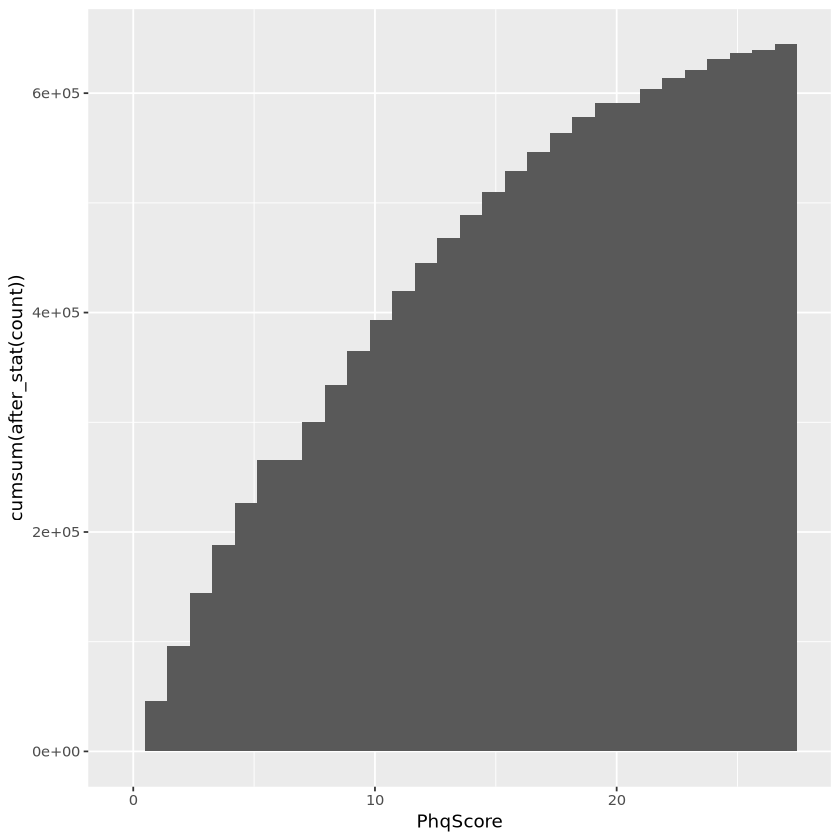

In [161]:
library(ggplot2)
ggplot(phqdfproviders,aes(x=PhqScore)) +
  stat_bin(aes(y=cumsum(after_stat(count))))

# ML models

### Prep ML model 

In [ ]:
mlsubset<-phqdfproviders %>% slice_sample(n=10000)

In [186]:
mlsubset<-mutate(mlsubset,Depressed=as.factor(Depressed),DepAny=as.factor(DepAny),phqDepressed=as.factor(phqDepressed),phqSevereDepressed=as.factor(phqSevereDepressed))

In [187]:
mlsubset %>% save(file="mlsubset.RData")

In [ ]:
mlsubset %>% table(mlsubset$Depressed)

### SVM Model

In [199]:
#set seed for random number generation
set.seed(10)
mlsubset<-mlsubset %>% ungroup() %>% select(BMI:phqDefDepressed,-X,-`NA`)
#split train and test data 80/20
mlsubset[,"train"] <- ifelse(runif(nrow(mlsubset))<0.8,1,0)
trainset <- mlsubset[mlsubset$train==1,]
testset <- mlsubset[mlsubset$train==0,]
#find “train” column index
trainColNum <- grep("train",names(trainset))
#remove column from train and test sets
trainset <- trainset[,-trainColNum]
testset <- testset[,-trainColNum]

In [200]:
trainset %>% colnames()

[1] "BMI"                   "SystolicBP"            "DiastolicBP"          
 [4] "Audit"                 "Phq2"                  "Diabetes"             
 [7] "Obesity"               "Hyperlipidemia"        "Depressed"            
[10] "Bipolar"               "Anxiety"               "Alcohol"              
[13] "Sleep"                 "SUD"                   "Tobacco"              
[16] "SchizophreniaSpectrum" "Adjustment"            "EatingDisorders"      
[19] "Hypertension"          "PTSD"                  "AdminDate.y"          
[22] "phqDepressed"          "phqSevereDepressed"    "DepAny"               
[25] "Age"                   "FPL"                   "Marital"              
[28] "Gender"                "Race"                  "Rural"                
[31] "Sex"                   "Sexor"                 "L1"                   
[34] "L2"                    "L3"                    "phqDefDepressed"

In [ ]:
#build default cost model with Encounter Diagnoses
library(e1071)
svm_model<- svm(Depressed~., data=trainset,type="C-classification", kernel="linear",cross=10)

In [ ]:
summary(svm_model)

In [177]:
#training accuracy
pred_train <- predict(svm_model,trainset)

In [178]:
mean(pred_train==trainset$Depressed)



Warning message in `==.default`(pred_train, trainset$Depressed):
“longer object length is not a multiple of shorter object length”
Warning message in is.na(e1) | is.na(e2):
“longer object length is not a multiple of shorter object length”


[1] 0.8924324

In [192]:
length(pred_train)
length(trainset$Depressed)

[1] 25030

[1] 515815

In [191]:
# Confusion matrix
library(caret)
confusionMatrix(data=pred_train,reference=trainset)

ERROR: Error in table(data, reference, dnn = dnn, ...): all arguments must have the same length


In [ ]:
cm = table(test_set[, 3], pred_train)

In [193]:
pred_test <- predict(svm_model,testset)
mean(pred_test==testset$Depressed)


ERROR: Error in model.frame.default(object, data, xlev = xlev): factor L3 has new levels Acute Care, Neonatal-Perinatal Medicine


In [167]:
set.seed(10)
accuracy <- rep(NA,100)
#calculate test accuracy for 100 different partitions
for (i in 1:100){
mlsubset[,"train"] <- ifelse(runif(nrow(mlsubset))<0.8,1,0)
trainColNum <- grep("train",names(mlsubset))
trainset <- mlsubset[mlsubset$train==1,-trainColNum]
testset <- mlsubset[mlsubset$train==0,-trainColNum]
svm_model <- svm(Depressed~ AdminDate, data=trainset, type="C-classification", kernel="linear")
pred_test <- predict(svm_model,testset)
accuracy[i] <- mean(pred_test==testset$Depressed)
}
mean(accuracy)
sd(accuracy)


ERROR: Error in eval(predvars, data, env): object 'AdminDate' not found


The models perform too well, even with information that should be basically random like Admin date

## Same as above but trying DepAny

In [165]:
#build default cost model with DepAny Diagnosis
library(e1071)
svm_model<- svm(DepAny~phqEnc, data=trainset,type="C-classification", kernel="linear")

ERROR: Error in eval(expr, p): object 'trainset' not found


In [ ]:
svm_model

In [ ]:
#training accuracy
pred_train <- predict(svm_model,trainset)

In [ ]:
mean(pred_train==trainset$DepAny)



In [ ]:
pred_test <- predict(svm_model,testset)
mean(pred_test==testset$DepAny)


In [ ]:

set.seed(10)
accuracy <- rep(NA,100)
#calculate test accuracy for 100 different partitions
for (i in 1:100){
mlsubset[,"train"] <- ifelse(runif(nrow(mlsubset))<0.8,1,0)
trainColNum <- grep("train",names(mlsubset))
trainset <- mlsubset[mlsubset$train==1,-trainColNum]
testset <- mlsubset[mlsubset$train==0,-trainColNum]
svm_model <- svm(DepAny~ AdminDate, data=trainset, type="C-classification", kernel="linear")
pred_test <- predict(svm_model,testset)
accuracy[i] <- mean(pred_test==testset$DepAny)
}
mean(accuracy) #.637
sd(accuracy) #.008



In [ ]:
# test of a full model with features 
mlsubsetSVM<-mlsubset  %>% select(AdminDate,INSTANCE_NUM,HEALTH_SYSTEM_ID,BMI:SEXORIENTATION_CD,DepAny,-`NA`,-train)

In [ ]:
mlsubsetSVM %>% colnames()

In [ ]:
# results of model with no demographic features
set.seed(10)
accuracy <- rep(NA,100)
#calculate test accuracy for 100 different partitions
for (i in 1:100){
mlsubsetSVM[,"train"] <- ifelse(runif(nrow(mlsubsetSVM))<0.8,1,0)
trainColNum <- grep("train",names(mlsubsetSVM))
trainset <- mlsubsetSVM[mlsubsetSVM$train==1,-trainColNum]
testset <- mlsubsetSVM[mlsubsetSVM$train==0,-trainColNum]
svm_model <- svm(DepAny~INSTANCE_NUM+BMI+SystolicBP+DiastolicBP+Diabetes+Obesity+Hyperlipidemia+Hypertension, data=trainset, type="C-classification", kernel="linear")
pred_test <- predict(svm_model,testset)
accuracy[i] <- mean(pred_test==testset$DepAny)
}
mean(accuracy) #.7145
sd(accuracy) #.00922



In [ ]:
#

### Decision Tree

In [ ]:
library(rpart)
#install.packages("rpart.plot")
#install.packages("rattle")

library(rpart.plot)

In [ ]:
Deptree <- rpart(mlsubset$Depressed ~ mlsubset$PhqScore)

In [ ]:
#provider tree with depressed encounter
Deptreeprov <- rpart(mlsubset$Depressed ~ mlsubset$L2+mlsubset$PhqScore)

In [ ]:
#provider tree with depressed any
Deptreeprov <- rpart(mlsubset$DepAny ~ mlsubset$L2+mlsubset$Race)

In [ ]:
Deptreeprov

In [ ]:
rpart.plot(Deptreeprov, cex=.3)

In [ ]:
Depanytree <- rpart(mlsubset$DepAny ~ mlsubset$HOMELESS_CD+mlsubset$HISPANIC_CD+mlsubset$RURAL_CD+mlsubset$CURRENT_FPL_CD+mlsubset$SEXORIENTATION_CD+mlsubset$SEX_CD
                    +mlsubset$RACE_CD+mlsubset$BMI+mlsubset$SystolicBP+mlsubset$DiastolicBP+mlsubset$Obesity+mlsubset$Hyperlipidemia+mlsubset$Hypertension)

In [ ]:
Depanytree

In [ ]:
rpart.plot(Depanytree, cex=.3)

In [ ]:
library(rattle)
fancyRpartPlot(Depanytree, caption = NULL)

pdf(file="depanytree1.pdf")
fancyRpartPlot(Depanytree, caption = NULL,cex=.3)
dev.off()